# MLSD Assignment 3 - Spectral Graph Clustering

Francisco Marques 97639 Data Science

In [1]:
%pip install pyspark
%pip install numpy 
%pip install networkx
%pip install scikit-learn
%pip install matplotlib
%pip install scipy

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy.signal import argrelextrema # get peaks
from sklearn.cluster import KMeans, SpectralClustering
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.clustering import PowerIterationClustering

### Read graphs to memory

In [3]:
graphs = []

directory = 'data/facebook'
for file in os.listdir(directory):
    if file.endswith('.edges'):
        graphs.append(nx.read_edgelist(f'{directory}/{file}')) #read graph from edge lists, it is undirected


### Compare clusters function

In [4]:
sc = SparkContext(appName="Assignment 3 - Graph Power Iteration")
spark = SparkSession.builder.appName("Assignment 3 - Graph Power Iteration").getOrCreate()
spark

### Function to cluster a graph

### Read graphs into Spark DF

In [5]:
spark_graphs = []

for file in os.listdir(directory):
    if file.endswith('.edges'):
        edges = spark.read.text(f'{directory}/{file}')
        edges = edges.rdd.map(lambda x: x[0].split(" ")).map(lambda row: (int(row[0]), int(row[1]))).toDF(['src', 'dst'])
        spark_graphs.append(edges)

In [8]:
def cluster_graph(graph, spark_graph):
    fig = plt.figure(1)
    fig, ax = plt.subplots(1, 5, figsize=(29, 5))

    pos = nx.spring_layout(graph) # generate coordinates for nodes
    
    plt.sca(ax[0])
    nx.draw_networkx(graph, pos = pos, with_labels = False, node_size = 4, width = 0.2)
    plt.title('Initial graph')
    
    laplacian = nx.normalized_laplacian_matrix(graph).toarray()
    
    eigvals, eigvecs = np.linalg.eig(laplacian)

    sorted_indices = np.argsort(eigvals) #indices of sorted eigenvalues
    sorted_eigenvalues = eigvals[sorted_indices] # sorted eigenvalues
    sorted_eigenvectors = eigvecs[:, sorted_indices] #sorted eigenvectors
    
    # eigengap
    eig_diff = np.diff(sorted_eigenvalues)
    peaks = argrelextrema(eig_diff, np.greater)[0] # unpack the tuple that is returned as there is only 1 dimension
    nb_clusters = peaks[0] + 1 # optimal number of cluster is first peak
    
    # eigenvalues plot
    plt.sca(ax[1])
    plt.scatter(range(len(sorted_eigenvalues)), sorted_eigenvalues, marker='*')
    plt.title('Eigenvalues')

    kmeans = KMeans(nb_clusters, n_init = 'auto').fit(np.real(sorted_eigenvectors[1:nb_clusters+1]).T)
    
    plt.sca(ax[2])
    nx.draw_networkx(graph, pos = pos, with_labels = False, node_size = 4, width = 0.2, node_color = kmeans.labels_)
    plt.title(f'Spectral clustering, $k = {nb_clusters}$')
    
    # sklearn spectral clustering
    clustering = SpectralClustering(n_clusters = nb_clusters, assign_labels = 'kmeans').fit(laplacian)
    
    plt.sca(ax[3])
    nx.draw_networkx(graph, pos = pos, with_labels = False, node_size = 4, width = 0.2, node_color = clustering.labels_)
    plt.title(f'sklearn Spectral Clustering, $k = {nb_clusters}$')
    
    # Spark Power Iteration
    assignments = PowerIterationClustering(k = nb_clusters).assignClusters(dataset = spark_graph).sort('id').rdd.map(lambda row: row[1]).collect()
    
    # only happened for phenomenology dataset where the dataset has slightly smaller size than the real graph
    # so we just add 0s as it wont make a noticeable difference in the results
    if abs(len(assignments) - len(graph)) > 0:
        for _ in range(abs(len(assignments) - len(graph))):
            assignments.append(0)
    
    plt.sca(ax[4])
    nx.draw_networkx(graph, pos = pos, with_labels = False, node_size = 4, width = 0.2, node_color = assignments)
    plt.title(f'Spark Power Iteration Clustering, $k = {nb_clusters}$')

## Facebook datasets

These graphs are relatively fast to cluster

c:\Users\franc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
c:\Users\franc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: T

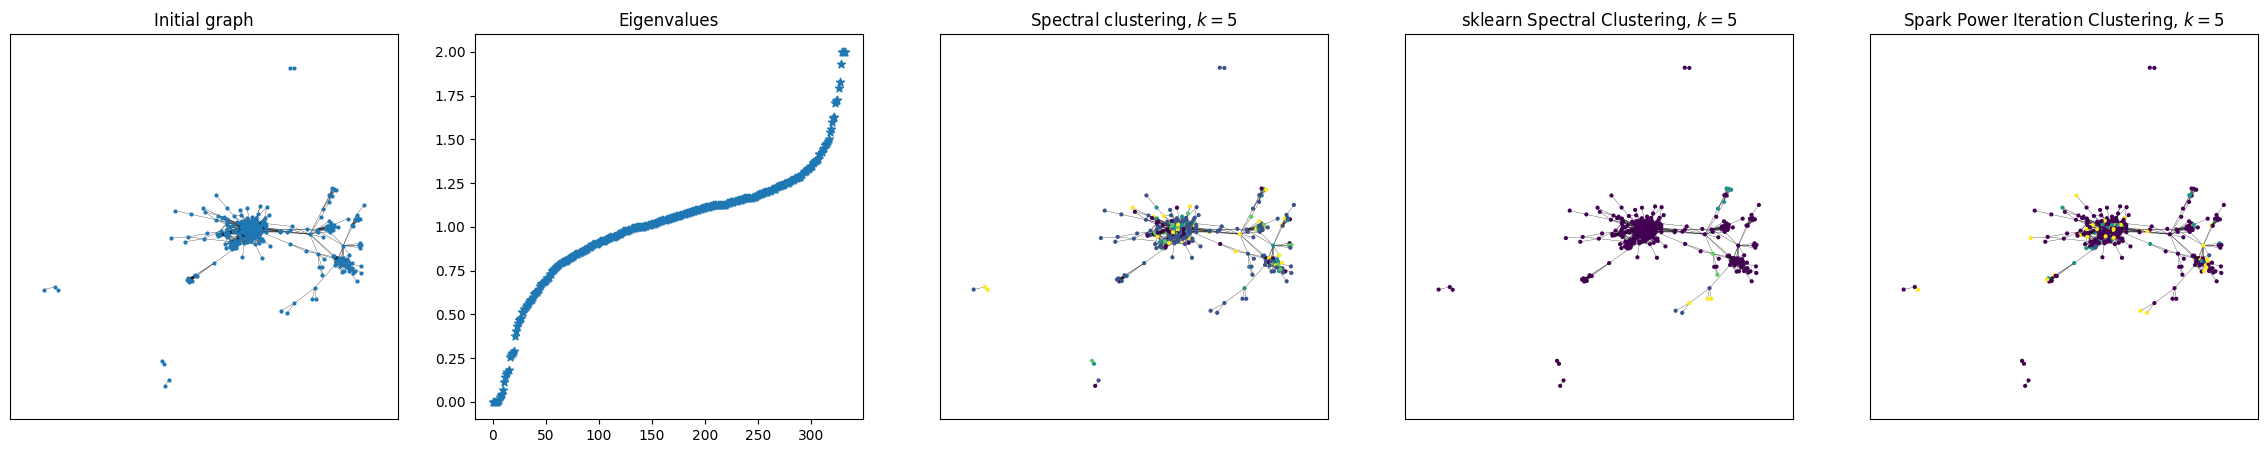

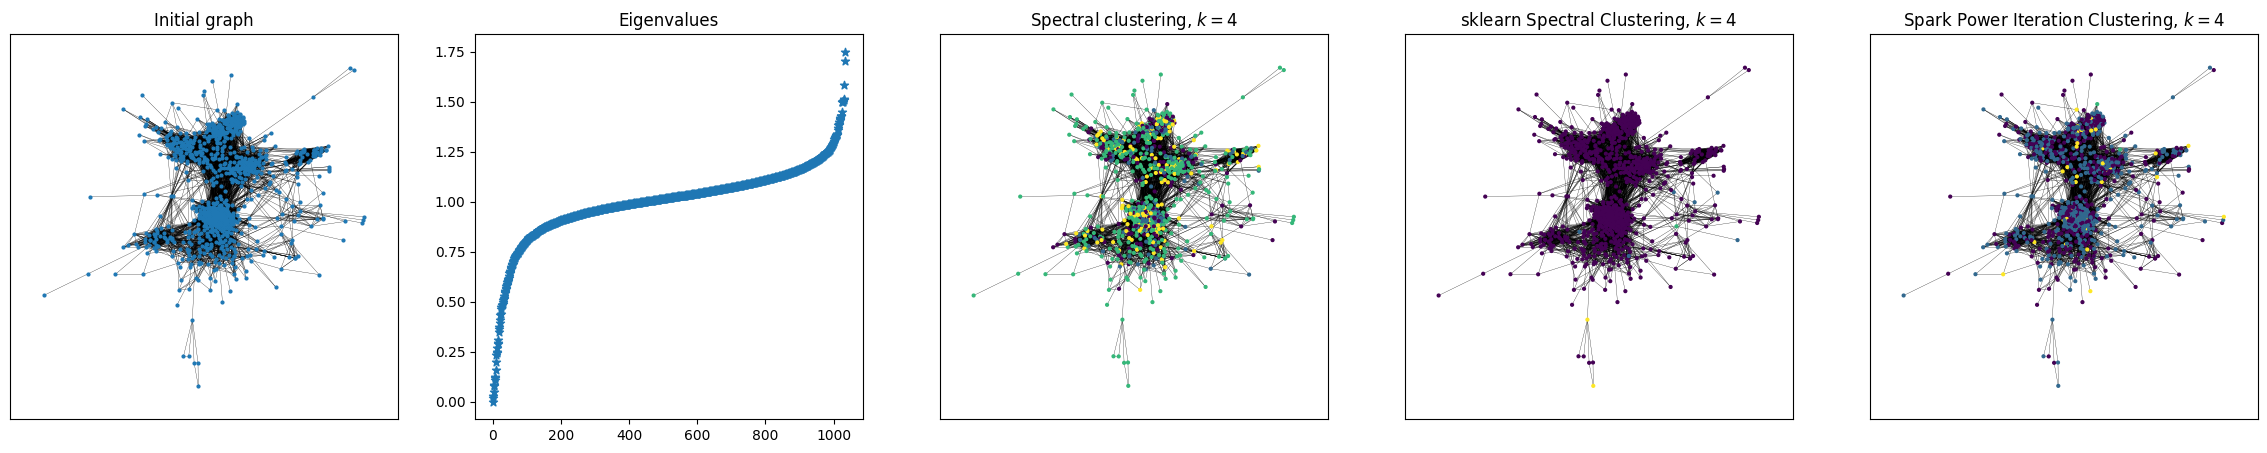

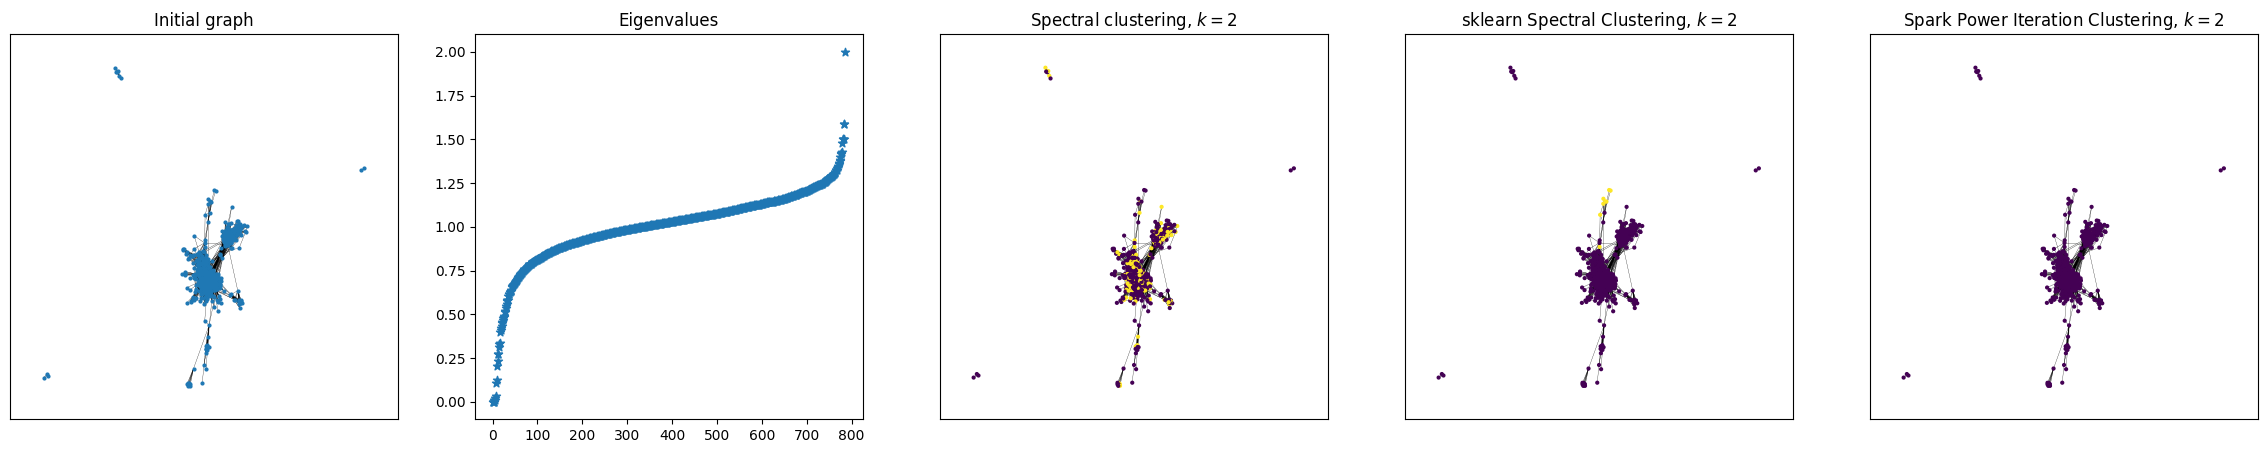

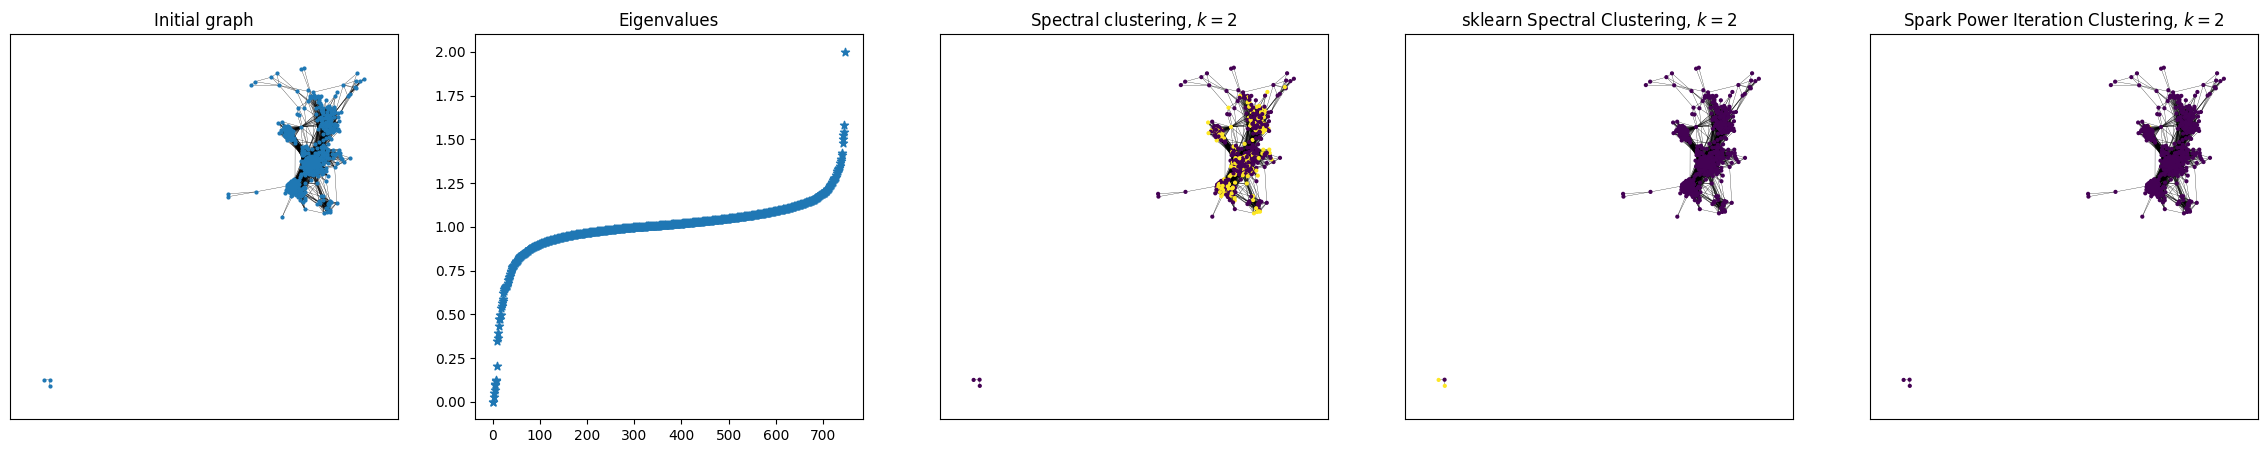

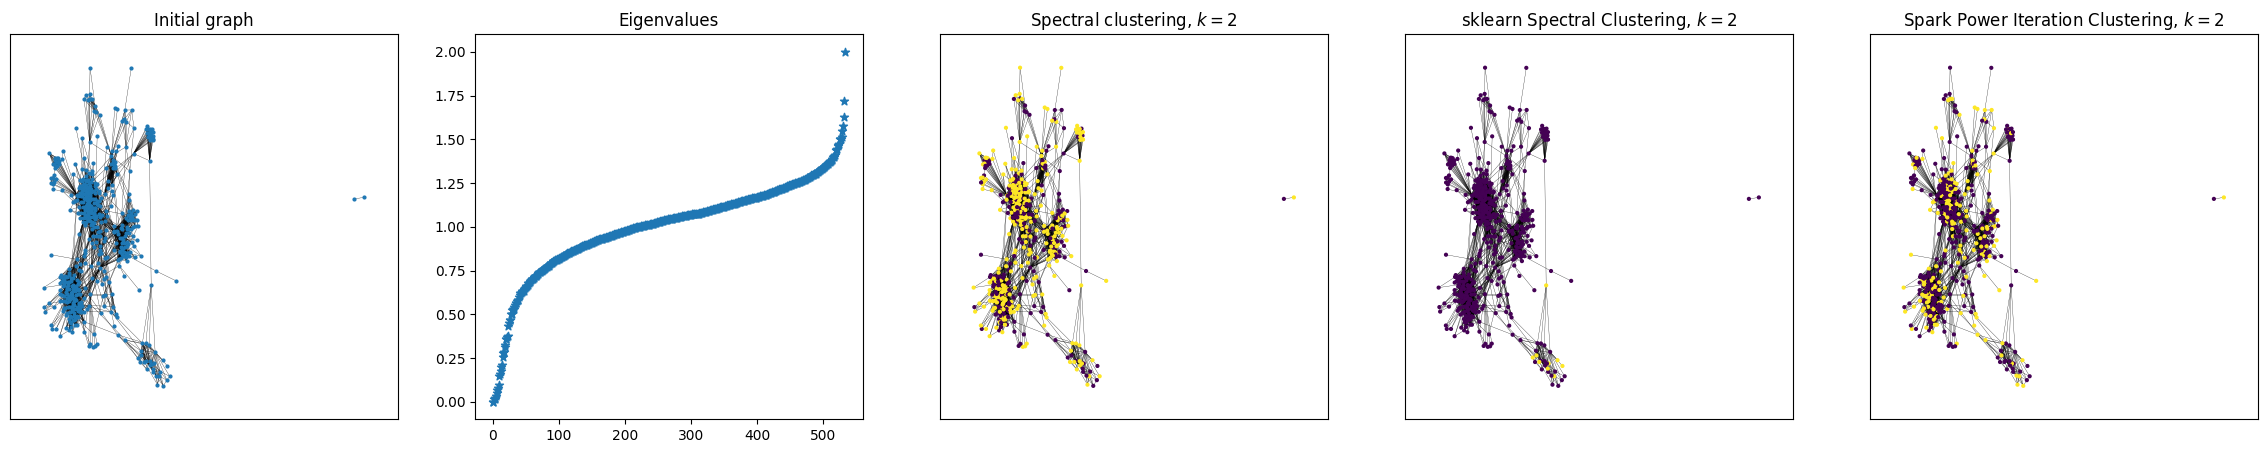

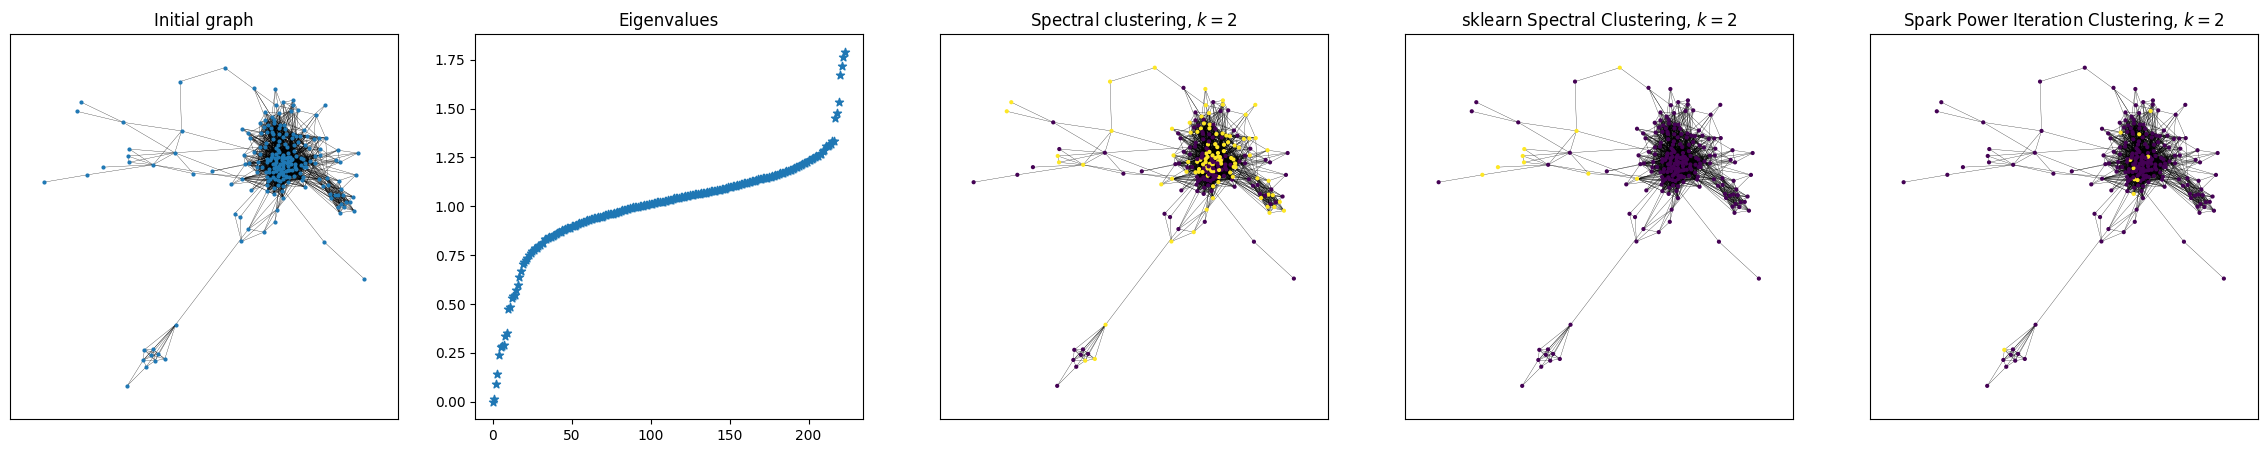

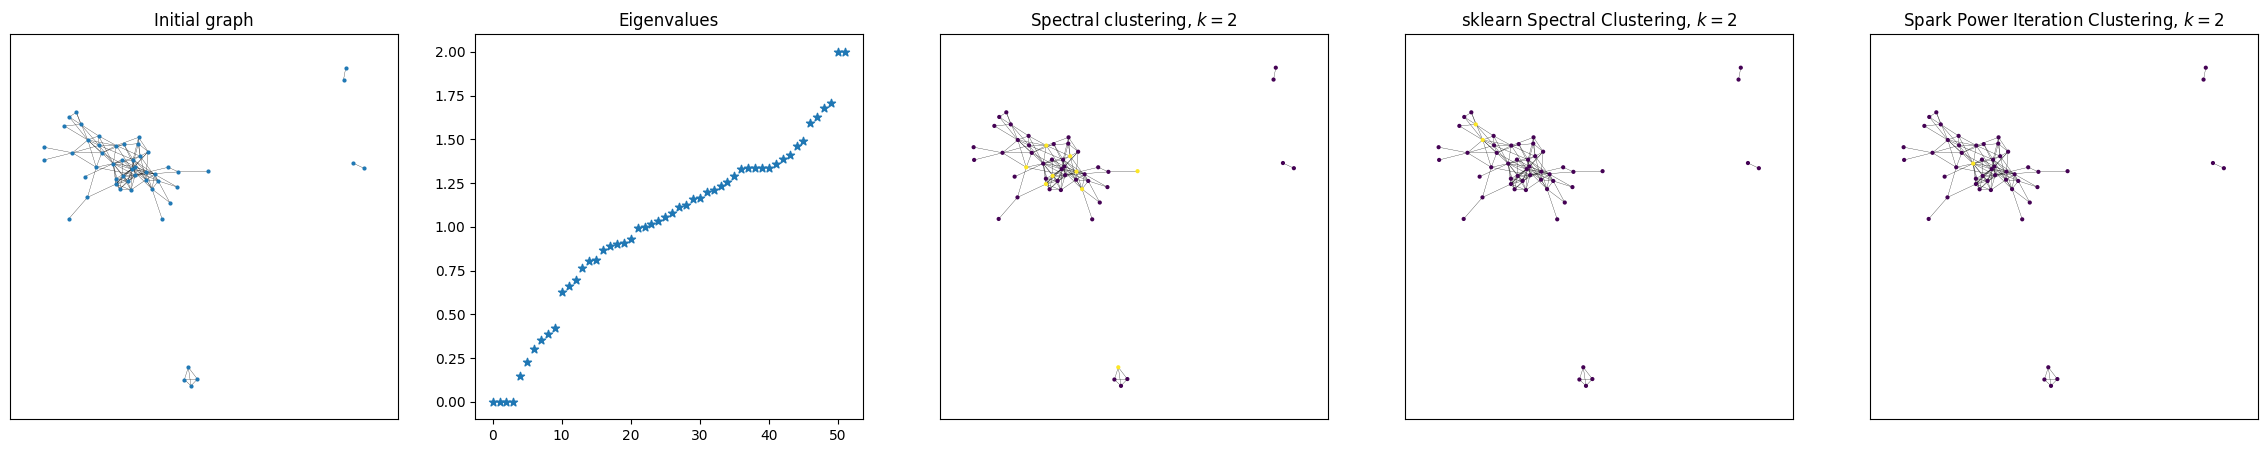

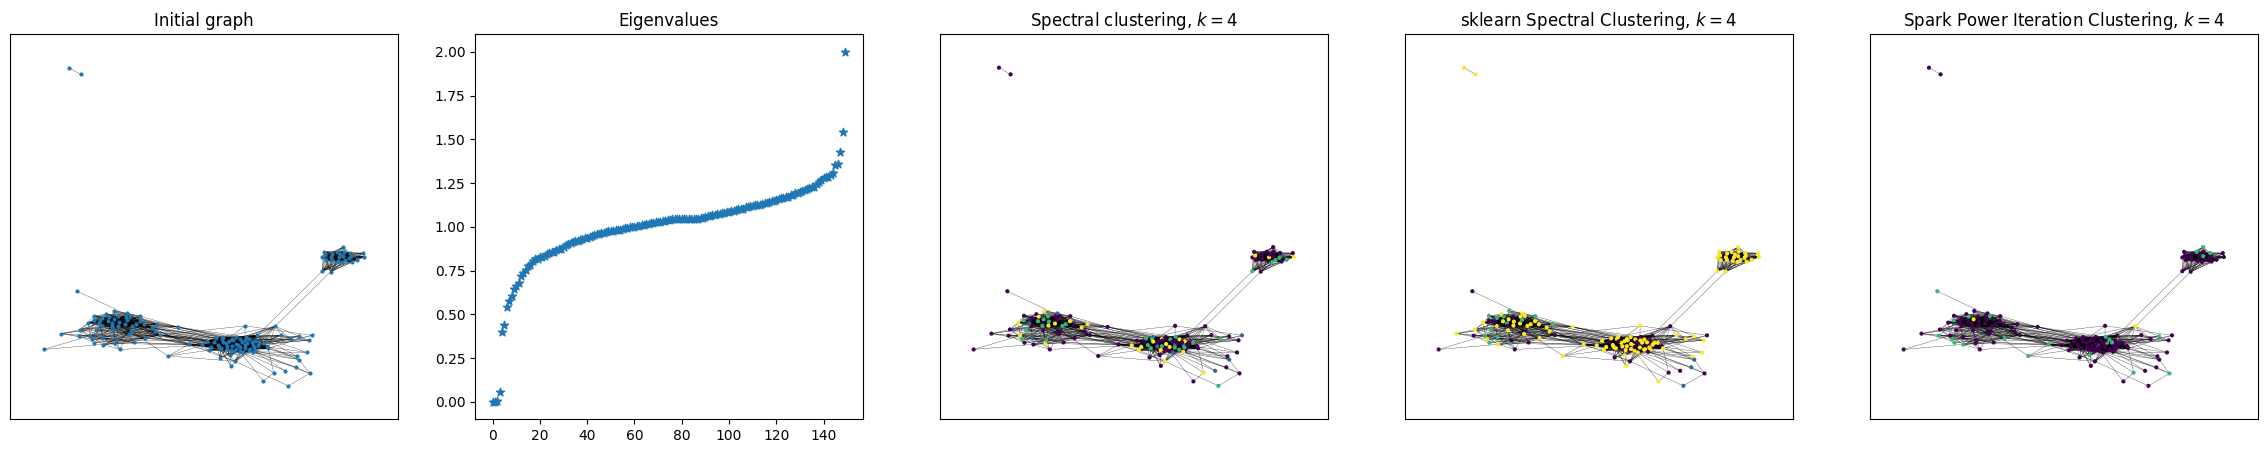

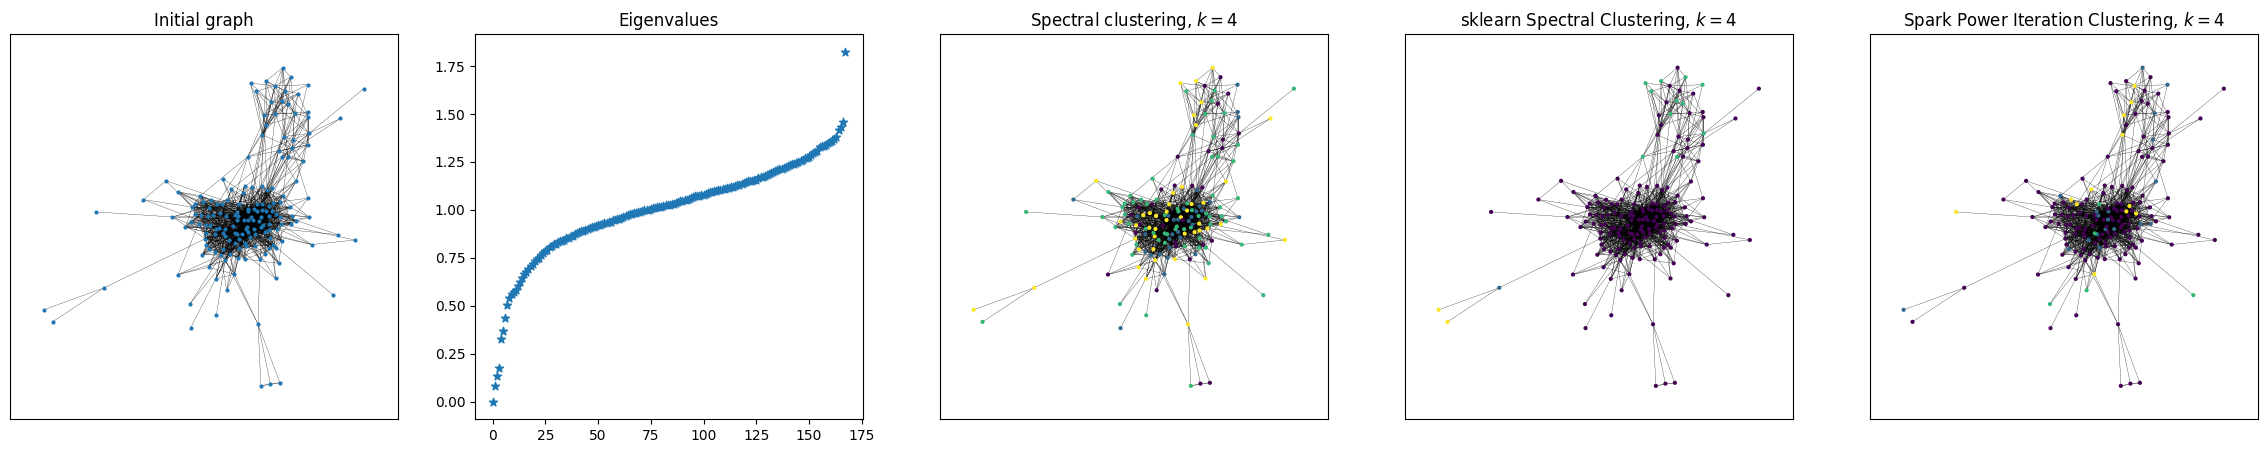

<Figure size 640x480 with 0 Axes>

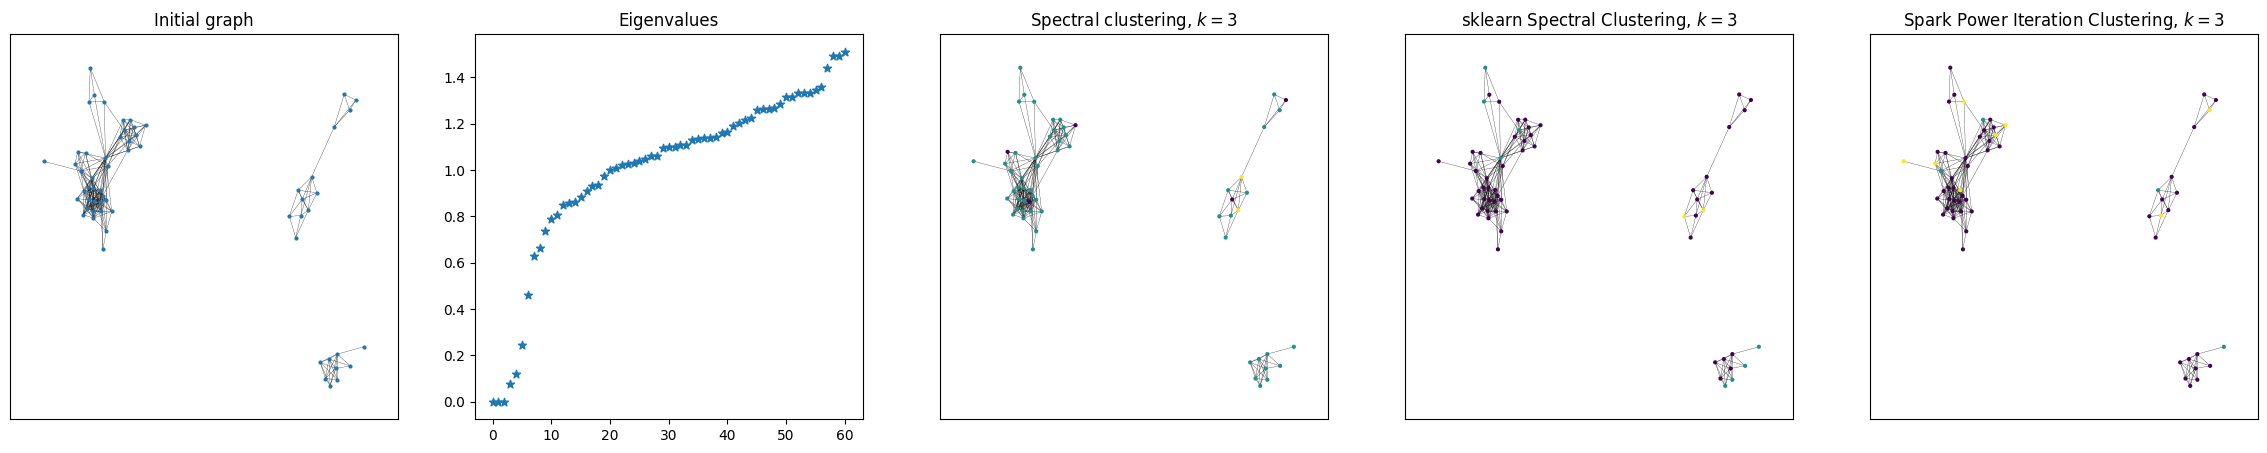

In [9]:
for i, G in enumerate(graphs):
    cluster_graph(G, spark_graphs[i])

We can see that both the sklearn and Spark algorithms result in very similar results. The difference to the implemented Spectral Clustering can be due to the clustering used, which was K-means.

### Phenomenology dataset

c:\Users\franc\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
c:\Users\franc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

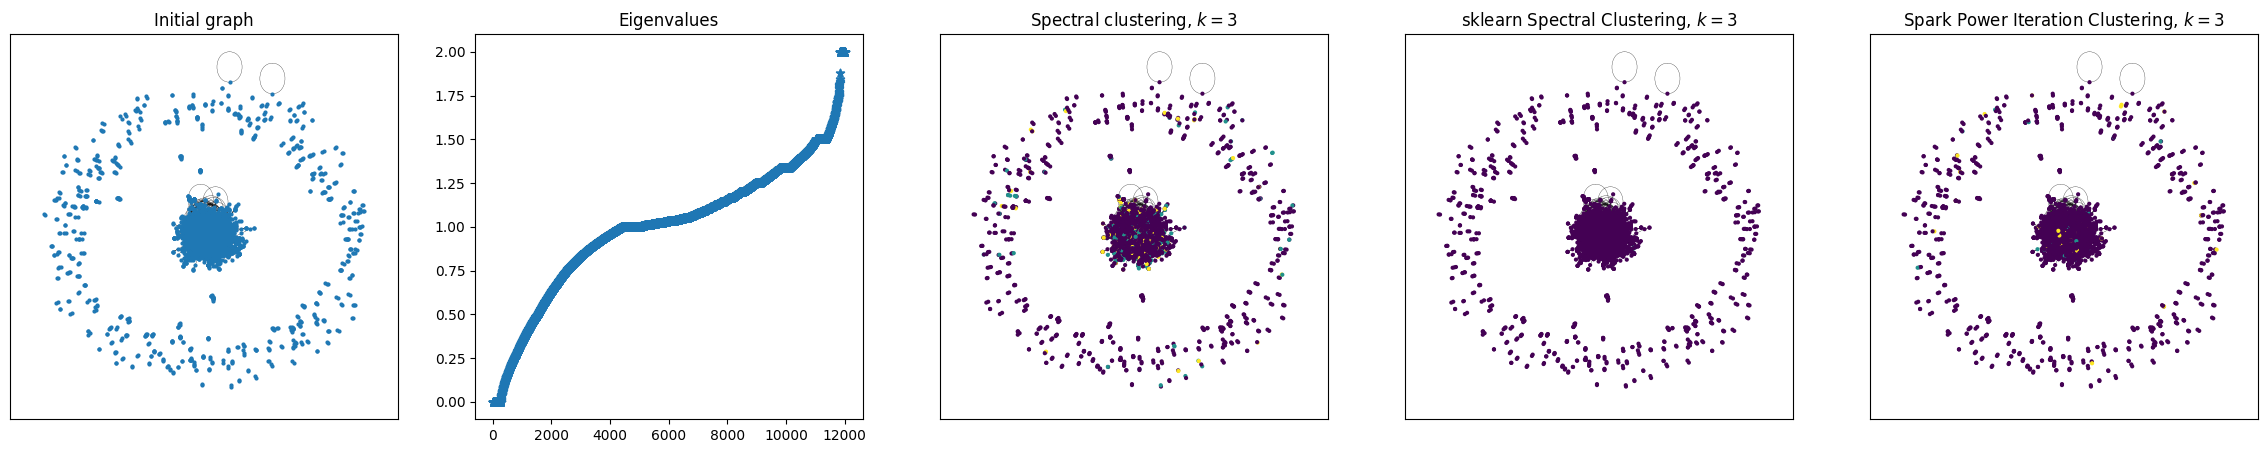

In [10]:
phenom_graph = nx.read_edgelist('data/CA-HepPh.txt')
phenom_spark_graph = spark.read.text('data/CA-HepPh.txt').rdd.filter(lambda row: '#' not in row[0]).map(lambda x: x[0].split("\t")).map(lambda row: (int(row[0]), int(row[1]))).toDF(['src', 'dst'])

cluster_graph(phenom_graph, phenom_spark_graph)

### Protein-protein interaction dataset

c:\Users\franc\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
c:\Users\franc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

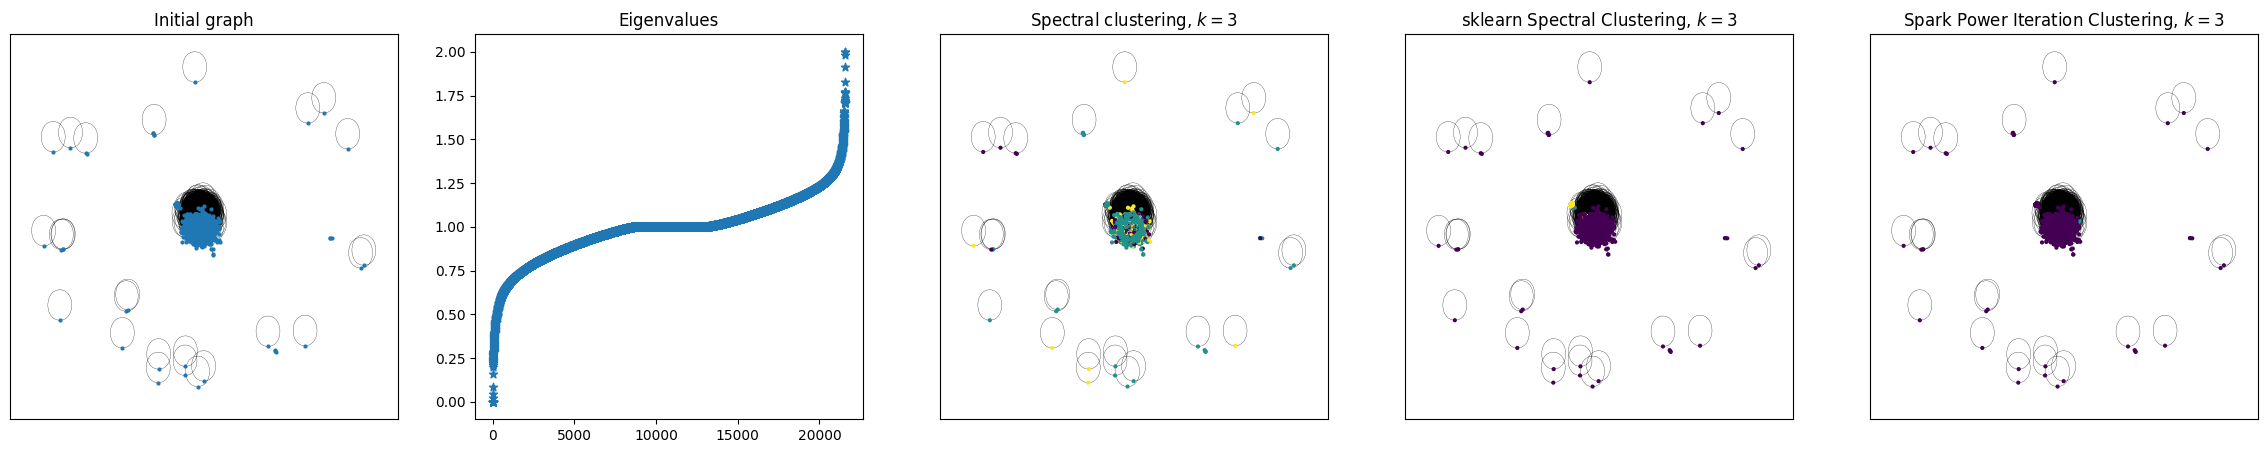

In [11]:
# Create graph from csv
protein_graph = nx.Graph()

with open('data/PP-Pathways_ppi.csv') as file:
    data = file.read().split('\n')
    for edge in data:
        if edge == '':
            continue
        u, v = edge.split(',')
        protein_graph.add_edge(u, v)

protein_spark_graph = spark.read.csv('data/PP-Pathways_ppi.csv').rdd.map(lambda row: (int(row[0]), int(row[1]))).toDF(['src', 'dst'])
  
# TAKES A LONG TIME due to very large laplacian (~320kx320k)
cluster_graph(protein_graph, protein_spark_graph)